In [124]:
from plotnine import *
import os, gc, datetime, time
import pandas as pd, numpy as np
from tqdm import tqdm_notebook
import warnings
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8] # setting figure size
warnings.filterwarnings(action='ignore')
pd.set_option('max_columns', 500)
pd.set_option('max_rows', 500)

In [125]:
train_trans = pd.read_csv("/Users/jeong/downloads/IEEE/input/train_transaction.csv")
train_idf = pd.read_csv("/Users/jeong/downloads/IEEE/input/train_identity.csv")

test_trans = pd.read_csv("/Users/jeong/downloads/IEEE/input/test_transaction.csv")
test_idf = pd.read_csv("/Users/jeong/downloads/IEEE/input/test_identity.csv")

In [126]:
train = pd.merge(train_trans, train_idf, on = 'TransactionID', how = 'left')
test = pd.merge(test_trans, test_idf, on = 'TransactionID', how = 'left')

#train['type'] = 'train'
#test['type'] = 'test'
#test['isFraud'] = -1

#tt = pd.concat([train, test], axis = 1)
#tt.shape

del train_trans, train_idf, test_trans, test_idf

In [127]:
ex_tr = train.groupby('id_31').agg({'isFraud':['count','mean']}).reset_index()
ex_tr.columns = ['id_31', 'cnt', 'prop']
ex_tr.sort_values('cnt', ascending= False, inplace = True)

ex_tr['cnt'] = ex_tr['cnt'] / ex_tr['cnt'].sum() 

ex_te = test.groupby('id_31').size().reset_index()
ex_te.columns = ['id_31', 'cnt']
ex_te.sort_values('cnt', ascending= False, inplace = True)

ex_te['cnt'] = ex_te['cnt'] / ex_te['cnt'].sum() 

print(ex_tr.head(5))
# print(ex_te.head(50))

                     id_31       cnt      prop
47             chrome 63.0  0.156827  0.068318
98      mobile safari 11.0  0.095686  0.062728
101  mobile safari generic  0.081792  0.099878
91     ie 11.0 for desktop  0.064370  0.019380
116         safari generic  0.058418  0.025015


In [71]:
ex_tr.loc[0:10,]


,id_31,cnt,prop


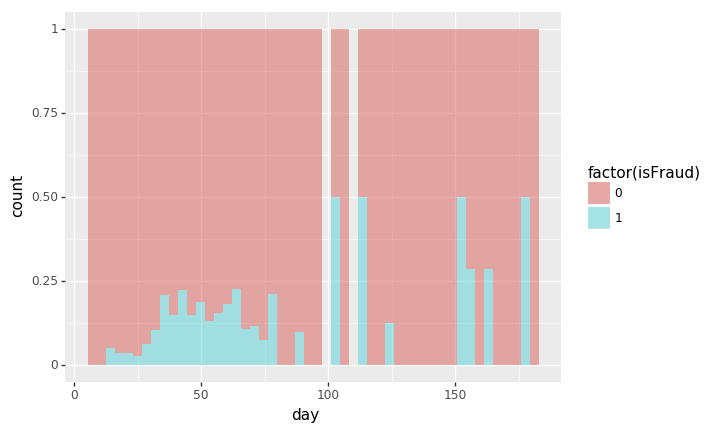

<ggplot: (7596408847)>

In [59]:
ex = train[train['id_31'] == 'chrome 63.0 for android']
ex = ex[ex['P_emaildomain'] == 'gmail.com']
ex['day'] = round(ex['TransactionDT'] / 60 / 60 / 24, 0)
ggplot(ex, aes('day', fill = 'factor(isFraud)')) + geom_histogram(bins = 50, alpha = 0.5)

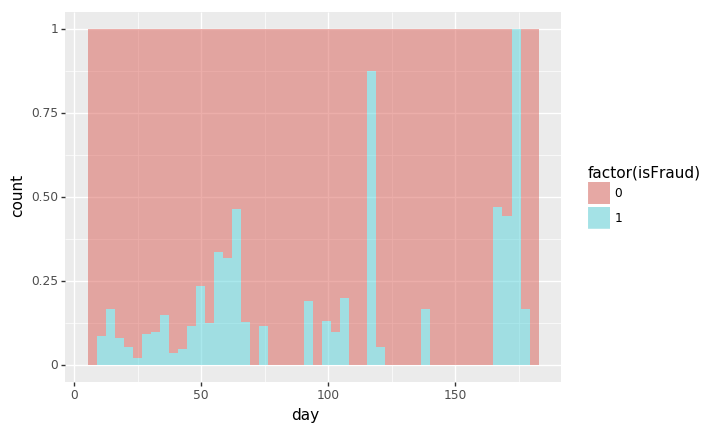

<ggplot: (7558464481)>

In [60]:
ex = train[train['id_31'] == 'chrome 63.0 for android']
ex = ex[ex['P_emaildomain'] != 'gmail.com']
ex['day'] = round(ex['TransactionDT'] / 60 / 60 / 24, 0)
ggplot(ex, aes('day', fill = 'factor(isFraud)')) + geom_histogram(bins = 50, alpha = 0.5)

chrome, mobile safari, ie, safari, chrome for android, edge에 대해
1) os 버전만 추출  
2) 해당 버전의 minmum day를 구하고, 차이를 구하기  
3) id_31 삭제  

In [137]:
train['day'] = round(train['TransactionDT'] / 60 / 60 / 24, 0)
test['day'] = round(test['TransactionDT'] / 60 / 60 / 24, 0)

In [76]:
tr = train[['day','id_31']]
te = test[['day','id_31']]

In [81]:
tt = pd.concat([tr, te], axis = 0)

In [88]:
ex = tt.groupby(['id_31']).agg({"day":['count','min']}).reset_index()
ex.columns = ['id_31','id_31_cnt' ,'os_mindate']
ex.sort_values('id_31_cnt', ascending = False, inplace = True)

In [90]:
train = pd.merge(train, ex, on = 'id_31', how = 'left')
test = pd.merge(test, ex, on = 'id_31', how = 'left')

In [92]:
train['os_mindate_tonow'] = train['day'] - train['os_mindate']
test['os_mindate_tonow'] = test['day'] - test['os_mindate']

train.drop(['os_mindate'], axis = 1, inplace = True)
test.drop(['os_mindate'], axis = 1, inplace = True)

KeyError: 'os_mindate'

In [128]:
def find_os_type(col):
    if ("chrome" in col) & ("for_android" in col) :
        return "chrome_android"
    elif ("chrome" in col)  :
        return "chrome"
    elif "mobile safari" in col :
        return "mobile_safari"
    elif "safari" in col :
        return "safari"
    elif "ie" in col :
        return "ie"
    elif "firefox" in col :
        return "firefox"
    else :
        return "etc"    

In [129]:
train['id_31_os_type'] = train['id_31'].astype('str').apply(find_os_type)
test['id_31_os_type'] = test['id_31'].astype('str').apply(find_os_type)

In [ ]:
# id_31 ㅂㅂ ~~
train.drop(['id_31'], axis = 1, inplace = True)
test.drop(['id_31'], axis = 1, inplace = True)

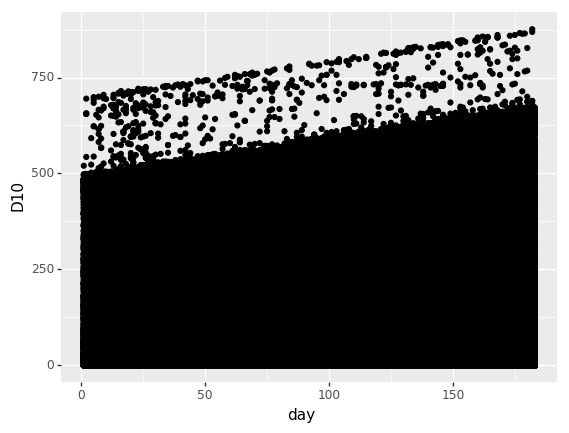

<ggplot: (-9223372029256696397)>

In [138]:
ggplot(train, aes('day','D10')) + geom_point()

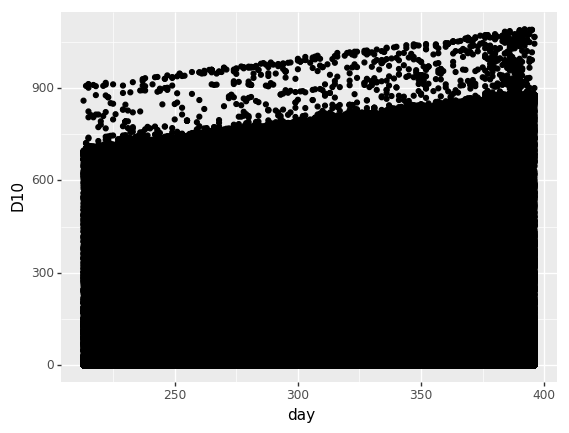

<ggplot: (-9223372029256696432)>

In [139]:
ggplot(test, aes('day','D10')) + geom_point()

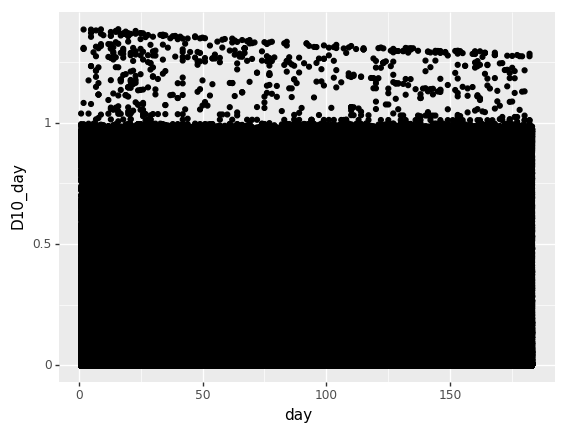

<ggplot: (-9223372029259665148)>

In [140]:
train['D10_day'] = train['D10'] / (train['day'] + 500)
test['D10_day'] = test['D10'] / (test['day'] + 500)
ggplot(train, aes('day','D10_day')) + geom_point()

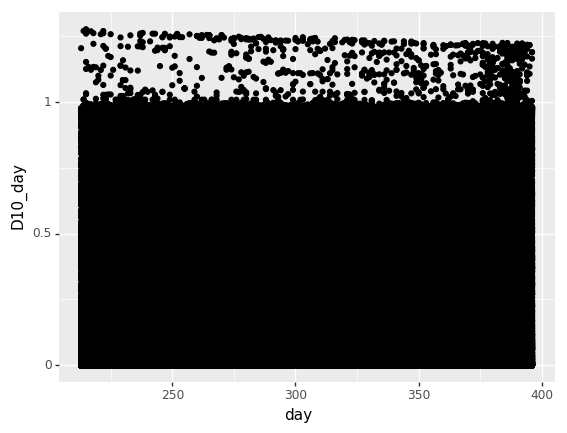

<ggplot: (-9223372029256588165)>

In [141]:
ggplot(test, aes('day','D10_day')) + geom_point()

In [145]:
train.C13.describe()

count    590540.000000
mean         32.539918
std         129.364844
min           0.000000
25%           1.000000
50%           3.000000
75%          12.000000
max        2918.000000
Name: C13, dtype: float64

In [147]:
ex = train.groupby('C13').size()
ex.columns = ['C13','cnt']
ex.head(10)

C13
0.0     35460
1.0    199337
2.0     57616
3.0     33033
4.0     23704
5.0     18355
6.0     15127
7.0     13001
8.0     11424
9.0     10189
dtype: int64

In [148]:
ex = test.groupby('C13').size()
ex.columns = ['C13','cnt']
ex.head(10)

C13
0.0     29778
1.0    168280
2.0     49947
3.0     27602
4.0     19240
5.0     15076
6.0     12659
7.0     10885
8.0      9603
9.0      8972
dtype: int64

In [149]:
train.C13.describe()

count    590540.000000
mean         32.539918
std         129.364844
min           0.000000
25%           1.000000
50%           3.000000
75%          12.000000
max        2918.000000
Name: C13, dtype: float64

In [150]:
test.C13.describe()

count    501943.000000
mean         27.816035
std         101.114033
min           0.000000
25%           1.000000
50%           3.000000
75%          13.000000
max        1562.000000
Name: C13, dtype: float64

In [151]:
train.C13.nunique()

1597

In [152]:
test.C13.nunique()

1069

In [155]:
(train.day.max() - train.day.min())

182.0

In [161]:
train['C13'].head()

0     1.0
1     1.0
2     1.0
3    25.0
4     1.0
Name: C13, dtype: float64

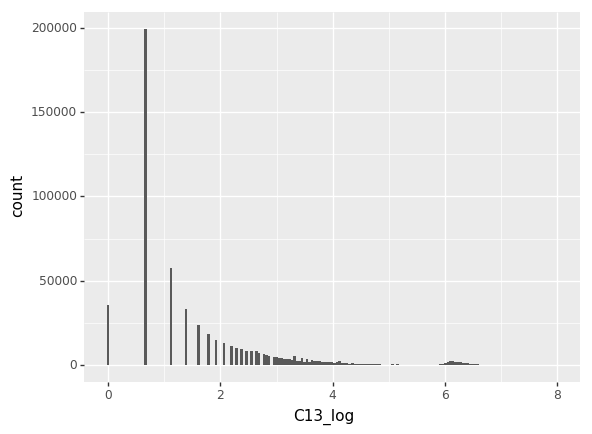

<ggplot: (7597343822)>

In [163]:
train['C13_log'] = np.log(train['C13']+1)
ggplot(train, aes('C13_log')) + geom_histogram()

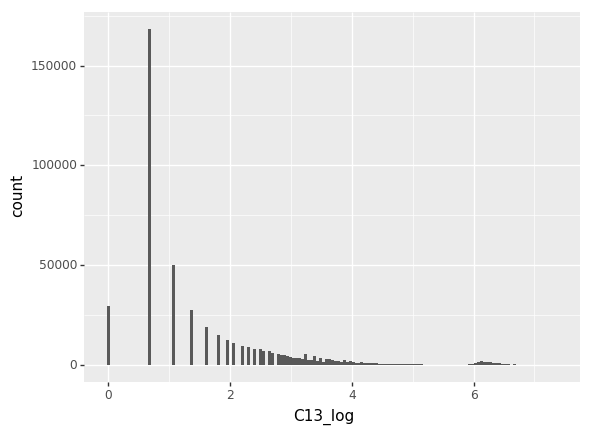

<ggplot: (7597307901)>

In [164]:
test['C13_log'] = np.log(test['C13']+1)
ggplot(test, aes('C13_log')) + geom_histogram()

In [165]:
train['C13_log'].describe()

count    590540.000000
mean          1.786342
std           1.452062
min           0.000000
25%           0.693147
50%           1.386294
75%           2.564949
max           7.978996
Name: C13_log, dtype: float64

In [166]:
test['C13_log'].describe()

count    501943.000000
mean          1.778281
std           1.412380
min           0.000000
25%           0.693147
50%           1.386294
75%           2.639057
max           7.354362
Name: C13_log, dtype: float64